In [60]:
import shap
from sklearn import svm
from sklearn.impute import SimpleImputer
import xgboost as xgb
import numpy as np
import pandas as pd
import statsmodels.api as sm
import category_encoders as ce

from category_encoders import CountEncoder
from category_encoders import WOEEncoder
from category_encoders import HashingEncoder

from sklearn.cluster import SpectralClustering
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x: '%.3f' % x)

import shutup
shutup.please()

In [36]:
def get_num_items(item):
    if not pd.isna(item):
        return len(item.split(","))
    else:
        item

In [37]:
def get_year(item):
    if not pd.isna(item):
        return int(str(item).split("-")[0])
    else:
        item

In [38]:
def get_num_and_non_num_cols(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_columns = df.select_dtypes(include=numerics).columns 
    non_numeric_cols = [col for col in df.columns if col not in numeric_columns]
    
    return numeric_columns, non_numeric_cols

In [47]:
class DataPreprocessor:
    def __init__(self, df_raw):
        self.clustering = None
        df_raw = df_raw.set_index("property_id")
        self._fit_geo_cluster(df_raw)
        df_raw['geo_cluster'] = self.clustering.labels_
        df_raw['geo_cluster'] = df_raw['geo_cluster'].astype(str)
        
        self.X_train, self.X_validation = train_test_split(df_raw, test_size=0.33, random_state=1982)
    
        self.y_train = None
        self.y_validation = None
        self.fitted_imputer = None
        self.pca_fit = None
        self.scaler = None
        self.binary_columns = None
        self.training_is_processed = False
        
        self.availability_cols = ['booking_availability_30', 
                                 'booking_availability_60', 
                                 'booking_availability_90']

    
    def _basic_column_preprocessor(self, X_train):
        
        X_train['num_amenities'] =       X_train['property_amenities'].apply(get_num_items)
        X_train['n_verified_channels'] = X_train['host_verified'].apply(get_num_items)
        X_train['host_since'] =          X_train['host_since'].apply(get_year)
        X_train['reviews_last'] =        X_train['reviews_last'].apply(get_year)
        X_train['reviews_first'] =       X_train['reviews_first'].apply(get_year)

        cols_drop=['property_sqfeet',
                   'property_name',
                   'property_summary',
                   'property_space', 
                   'property_desc',
                   'property_neighborhood',
                   'property_notes',
                   'property_transit',
                   'property_access',
                   'property_interaction', 
                   'property_rules', 
                   'host_about',
                   'host_response_time',
                   'host_location',
                   'host_id',
                   'extra', 
                   'host_verified',
                   'property_amenities',
                   'property_last_updated',
                   'host_nr_listings_total',
                   'property_zipcode',
                   'property_scraped_at',
                   'property_lat', 
                   'property_lon']

        X_train=X_train.drop(columns=cols_drop)
        
        return X_train
    
    def _fit_geo_cluster(self, df_raw, n_clusters=28):
        corrdinates = ['property_lat', 'property_lon']
        self.clustering = (SpectralClustering(n_clusters=n_clusters, 
                                assign_labels='discretize',
                                random_state=0).fit(df_raw[corrdinates]))
    
    def _fit_mode_imputer(self):                
        imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self.fitted_imputer = imp_mode.fit(self.X_train)

    def _transform_mode_imputer(self, X_train):
        numeric_columns, non_numeric_cols = get_num_and_non_num_cols(X_train)
        
        cols = X_train.columns
        index = X_train.index
        X_train = pd.DataFrame(self.fitted_imputer.transform(X_train))
        X_train.columns = cols
        X_train.index = index
        X_train[numeric_columns] = X_train[numeric_columns].apply(pd.to_numeric)
        
        return X_train
        
    def _fit_pca_availability(self):
        pca = PCA(n_components = 1)
        self.pca_fit = pca.fit(self.X_train[self.availability_cols])

    def _transform_pca_availability(self, X_train):
        X_train['availability'] = self.pca_fit.transform(X_train[self.availability_cols])
        X_train.drop(self.availability_cols, axis=1, inplace=True)
        return X_train
        
    def _fit_min_max_scaler(self):
        numeric_columns, non_numeric_cols = get_num_and_non_num_cols(self.X_train)
        self.scaler = preprocessing.MinMaxScaler().fit(self.X_train[numeric_columns])
        
    def _transform_min_max_scaler(self, X_train):
        numeric_columns, non_numeric_cols = get_num_and_non_num_cols(X_train)
        X_scaled = pd.DataFrame(self.scaler.transform(X_train[numeric_columns]))
        X_scaled.columns = numeric_columns
        X_scaled.index = X_train.index 
        return X_scaled
    
    def _binarize_categoricals(self, X_train):
        numeric_columns, non_numeric_cols = get_num_and_non_num_cols(X_train)
        X_binarized = pd.get_dummies(X_train[non_numeric_cols])
        return X_binarized
    
    def _fit_dummies(self):
        numeric_columns, non_numeric_cols = get_num_and_non_num_cols(self.X_train)
        self.binary_columns = pd.get_dummies(self.X_train[non_numeric_cols]).columns

    def _transform_dummies(self, X_train):
        numeric_columns, non_numeric_cols = get_num_and_non_num_cols(X_train)
        X_train = pd.get_dummies(X_train[non_numeric_cols])
        return X_train.reindex(columns=self.binary_columns, fill_value=0)

    def preprocess_training(self):
        self.X_train = self._basic_column_preprocessor(self.X_train)
        
        self._fit_mode_imputer()
        self.X_train = self._transform_mode_imputer(self.X_train)
        
        self._fit_pca_availability()
        self.X_train = self._transform_pca_availability(self.X_train)
        
        self._fit_min_max_scaler()
        X_scaled = self._transform_min_max_scaler(self.X_train)
        
        self._fit_dummies()
        X_binarized = self._transform_dummies(self.X_train)
        
        self.X_train = pd.merge(X_binarized, X_scaled, left_index=True, right_index=True)
        self.y_train = self.X_train.target
        self.X_train.drop(columns="target", inplace=True)
        self.training_is_processed = True
        
    def preprocess_validation(self):
        if self.training_is_processed:
            self.X_validation = self._basic_column_preprocessor(self.X_validation)
            self.X_validation = self._transform_mode_imputer(self.X_validation)
            self.X_validation = self._transform_pca_availability(self.X_validation)
            X_scaled =          self._transform_min_max_scaler(self.X_validation)
            X_binarized =       self._transform_dummies(self.X_validation)
            self.X_validation = pd.merge(X_binarized, X_scaled, left_index=True, right_index=True)
            self.y_validation = self.X_validation.target
            self.X_validation.drop(columns="target", inplace=True)
        else:
            raise ValueError('Training must be preprocessed prior to validation')

In [48]:
df_raw = pd.read_csv("train.csv")

In [49]:
processor = DataPreprocessor(df_raw)
processor.preprocess_training()
processor.preprocess_validation()

## XGboost

### Cross validation

In [53]:
regressor=xgb.XGBRegressor(eval_metric='rmse')

param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=5).fit(processor.X_train, processor.y_train)

### Best parameters

In [54]:
search.best_params_["learning_rate"], search.best_params_["n_estimators"], search.best_params_["max_depth"]

(0.01, 500, 4)

In [55]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

model = regressor.fit(processor.X_train, processor.y_train)

### RMSE

In [56]:
predictions = regressor.predict(processor.X_validation)
RMSE = np.sqrt(mean_squared_error(processor.y_validation, predictions))
RMSE

0.062242247438400074

## SVM model

In [71]:
rlf = svm.SVR()
svm_fit = rlf.fit(processor.X_train, processor.y_train)

### RMSE

In [72]:
np.sqrt(mean_squared_error(processor.y_validation,svm_fit.predict(processor.X_validation)))

0.07633518479268288

### Feature importance

In [57]:
explainer = shap.Explainer(model)
shap_values = explainer(processor.X_train)

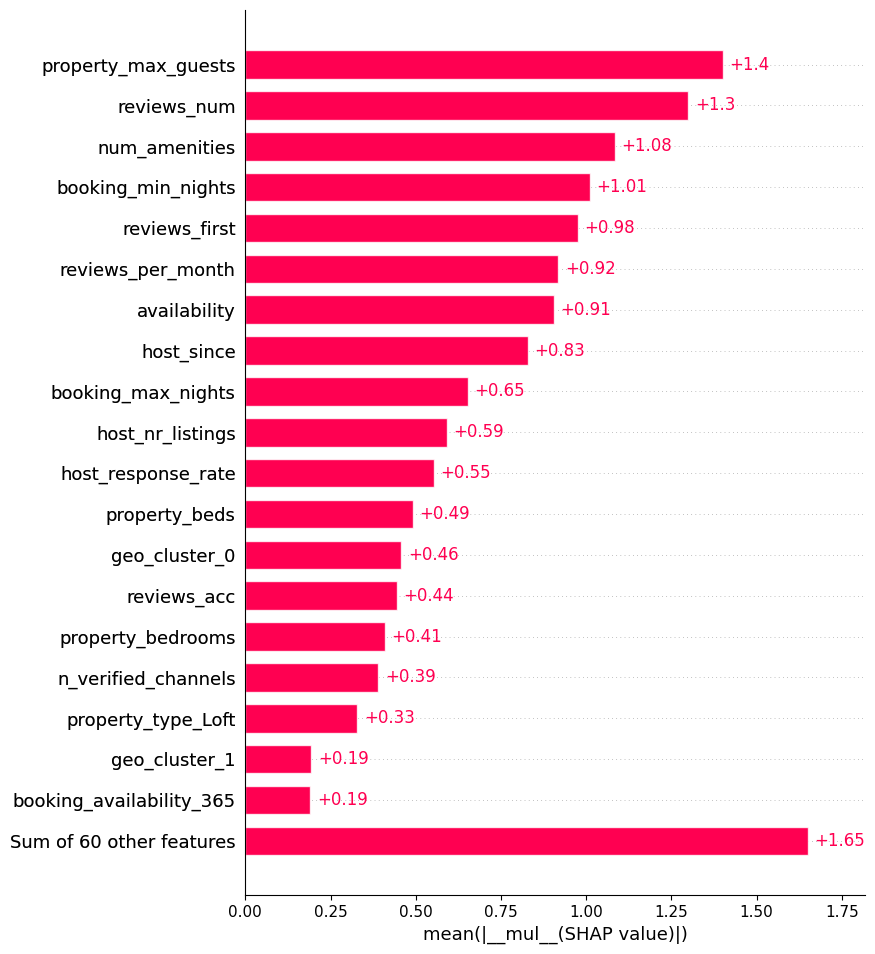

In [58]:
shap.plots.bar(shap_values*1000, max_display=20)